# Imports

In [1]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_selection import SelectFromModel
import time

In [2]:
from pylab import *
import numpy as np
from matplotlib.ticker import ScalarFormatter
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib.ticker import AutoMinorLocator
from matplotlib.colors import LogNorm
from matplotlib.patches import Ellipse

# Get the data

In [3]:
all_data = []
all_labels = []

for i in np.random.choice(2000,2000, replace=False):
    pk = np.loadtxt('//mnt/ceph/users/fvillaescusa/Ana/matter/latin_hypercube/%d/Pk_m_z=0.txt'%i)
    mask = pk[:,0] <=0.5
    pk_new = pk[mask]
    cosmo_params = np.loadtxt('//mnt/ceph/users/fvillaescusa/Ana/latin_hypercube/latin_hypercube_params.txt')[i]
    all_data.append(pk_new)
    all_labels.append(cosmo_params)

In [4]:
len(all_data)

2000

In [5]:
all_data = np.array(all_data).reshape(len(all_data),-1)
all_labels = np.array(all_labels)

In [6]:
all_data.shape

(2000, 158)

# Split the data into 80% training, 20% testing

In [7]:
X_train, X_test, y_train, y_test = train_test_split(all_data, all_labels, test_size=0.2, random_state=0)

# train/test check 
(Checks for high variance)

In [8]:
def checktraintestreg(model, ntrials =5):

    scores_train = np.zeros(ntrials)
    scores_test = np.zeros(ntrials)

    for i in range(ntrials):
        model.fit(X_train, y_train)
        pred_test = model.predict(X_test)
        pred_train = model.predict(X_train)

        scores_test[i] = (metrics.r2_score(y_test,pred_test))
        scores_train[i] =(metrics.r2_score(y_train,pred_train))

    print('Training scores '+str(scores_train.mean())+' +- '+str(scores_train.std()))
    print('Test scores '+str(scores_test.mean())+' +- '+str(scores_test.std()))

In [9]:
checktraintestreg(RandomForestRegressor(n_estimators=20, min_samples_leaf=5))

Training scores 0.7137477108890298 +- 0.00144463955808358
Test scores 0.48002580392786137 +- 0.003998063335561508


In [10]:
checktraintestreg(RandomForestRegressor(n_estimators=20, min_samples_leaf=1))

Training scores 0.9228671368620136 +- 0.0014665121395408668
Test scores 0.49060247846524235 +- 0.008792070942619532


In [11]:
checktraintestreg(RandomForestRegressor(n_estimators=100, min_samples_leaf=1))

Training scores 0.9351348331843579 +- 0.0007285200978787568
Test scores 0.5089368040401934 +- 0.004316386879635271


In [12]:
checktraintestreg(RandomForestRegressor(n_estimators=100, min_samples_leaf=5))

Training scores 0.7207325342484711 +- 0.0004386829049344404
Test scores 0.4917255855963122 +- 0.0037547859572206336


In [13]:
checktraintestreg(RandomForestRegressor(n_estimators=200, min_samples_leaf=5))

Training scores 0.7215686334077291 +- 0.0004124310633210193
Test scores 0.4935445789689261 +- 0.0011199519075788397


# Train the model

In [14]:
model = RandomForestRegressor(n_estimators=100, min_samples_leaf=5, n_jobs= 5)

In [15]:
start= time.time()

model.fit(X_train, y_train)

print('Time (s):', "{:.4f}".format((time.time()-start)))

Time (s): 10.6289


In [16]:
ypred=model.predict(X_test)

# Results

In [17]:
def obtain_cosmo_params_rmse(test_data, prediction_data, title):
    scores={}
    maxmin={}
    om_score =np.sqrt(metrics.mean_squared_error(test_data[:,0],prediction_data[:,0]))
    ob_score =np.sqrt(metrics.mean_squared_error(test_data[:,1],prediction_data[:,1]))
    h_score =np.sqrt(metrics.mean_squared_error(test_data[:,2],prediction_data[:,2]))
    ns_score =np.sqrt(metrics.mean_squared_error(test_data[:,3],prediction_data[:,3]))
    s8_score =np.sqrt(metrics.mean_squared_error(test_data[:,4],prediction_data[:,4]))
    scores.update([('omega m rmse', om_score)])
    scores.update([('omega b rmse', ob_score)])
    scores.update([('h rmse', h_score)])
    scores.update([('Ns rmse', ns_score)])
    scores.update([('sigma 8 rmse', s8_score)])
    np.save(title, scores)
    
    maxmin.update([(('omega m min', np.min(prediction_data[:,0])), ('omega m max', np.max(prediction_data[:,0])))])
    maxmin.update([(('omega b min', np.min(prediction_data[:,1])), ('omega b max', np.max(prediction_data[:,1])))])
    maxmin.update([(('h min', np.min(prediction_data[:,2])), ('h max', np.max(prediction_data[:,2])))])
    maxmin.update([(('Ns min', np.min(prediction_data[:,3])), ('Ns max', np.max(prediction_data[:,3])))])
    maxmin.update([(('sigma 8 min', np.min(prediction_data[:,4])), ('sigma 8 max', np.max(prediction_data[:,4])))])
    
    return scores, maxmin

In [18]:
obtain_cosmo_params_rmse(y_test, ypred, 'RF_Pk_0.5_scores_8_30')

({'omega m rmse': 0.04300839648066292,
  'omega b rmse': 0.011416931557400261,
  'h rmse': 0.09745213544798369,
  'Ns rmse': 0.09759735823953747,
  'sigma 8 rmse': 0.01568411324376664},
 {('omega m min', 0.11873344400942196): ('omega m max', 0.4566294819672157),
  ('omega b min', 0.04326639068304245): ('omega b max', 0.05757515419719173),
  ('h min', 0.5540417978341919): ('h max', 0.8330796673068755),
  ('Ns min', 0.8661168681552109): ('Ns max', 1.1222452182715983),
  ('sigma 8 min', 0.6130726467308316): ('sigma 8 max', 0.975274578249528)})

<Figure size 432x288 with 0 Axes>

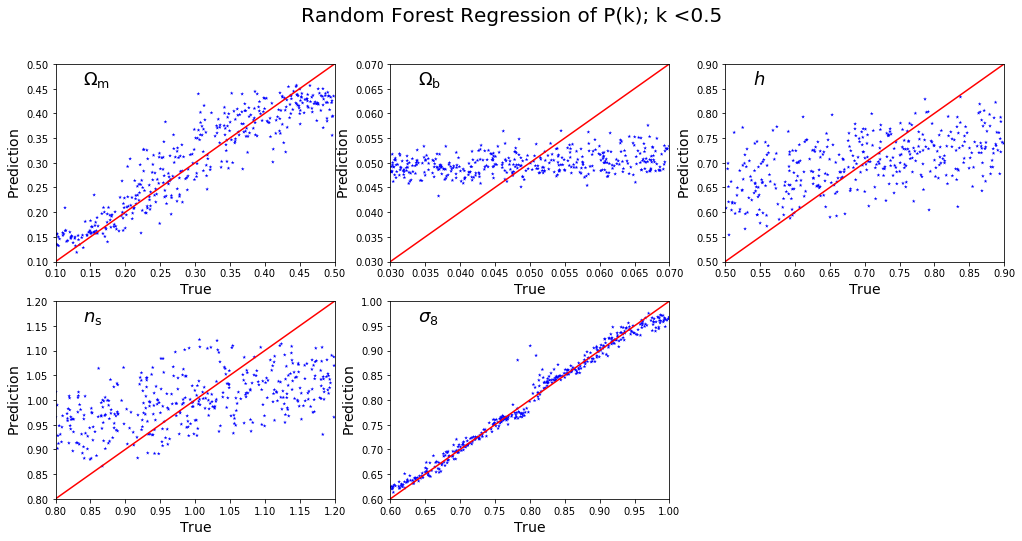

In [19]:
fig = figure()
fig = figure(figsize=(17,8))     #give dimensions to the figure

#gs =  gridspec.GridSpec(2,3,height_ratios=[1,1,1],width_ratios[1,1])
gs =  gridspec.GridSpec(2,3)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])
ax4 = plt.subplot(gs[3])
ax5 = plt.subplot(gs[4])
#ax6 = plt.subplot(gs[5])

x_min, x_max = 0.1, 0.5
y_min, y_max = 0.1, 0.5

param_min = [0.1, 0.03, 0.5, 0.8, 0.6]
param_max = [0.5, 0.07, 0.9, 1.2, 1.0]

label = [r"$\Omega_{\rm m}$", r"$\Omega_{\rm b}$", r"$h$",
         r"$n_{\rm s}$", r"$\sigma_8$"]

x_dumb = np.linspace(-15,15,100) #larger values for when outliers are included in plot


#f1 = '../results.txt'
#f_out='../plots/NN_cosmo_params_32.pdf'
#data = np.loadtxt(f1)

for i,ax in enumerate([ax1,ax2,ax3,ax4,ax5]):

    ax.set_xlim([param_min[i],param_max[i]])
    ax.set_ylim([param_min[i],param_max[i]])
    #ax.set_xlim([np.min(ypred_all[:,i]), np.max(ypred_all[:,i])]) #for plotting the ouliers
    #ax.set_ylim([1.05*np.min(ypred_all[:,i]), 1.05*np.max(ypred_all[:,i])]) #for plotting the outliers


    ax.set_xlabel(r'${\rm True}$',fontsize=14)
    ax.set_ylabel(r'${\rm Prediction}$',fontsize=14)

    p1=ax.scatter(y_test[:,i], ypred[:,i],c='b',edgecolor='none',s=15,marker='*')
    ax.plot(x_dumb, x_dumb, linestyle='-', c='r')

    posx = param_min[i] + 0.1*(param_max[i] - param_min[i])
    posy = param_min[i] + 0.9*(param_max[i] - param_min[i])
    ax.text(posx, posy, label[i], size=18)

#plt.savefig('RF_NCV_all_present.jpg')

#place a label in the plot
#ax1.text(0.2,0.1, r"$z=4.0$", fontsize=22, color='k')

#legend
#ax1.legend([p1,p2],
#           [r"$z=3$",
#            r"$z=4$"],
#           loc=0,prop={'size':18},ncol=1,frameon=True)
            
            #columnspacing=2,labelspacing=2)




#ax1.set_title(r'$\sum m_\nu=0.0\/{\rm eV}$',position=(0.5,1.02),size=18)
#title('About as simple as it gets, folks')
suptitle('Random Forest Regression of P(k); k <0.5 ', fontsize=20)  #for title with several panels
#grid(True)
#show()
savefig('RF_Pk_0.5_8_30.pdf', bbox_inches='tight')
#close(fig)